In [1]:
%matplotlib notebook
import jplus
import os
import pickle
import elgtools as elg
import numpy as np
import matplotlib.pyplot as plt
import Read_Mocks as read
import MockJPLUS as mtools

Mockpath = '/home/CEFCA/aaorsi/work/JPLUS_Mock/'
namelc   = 'LightCone_SA_0_'


In [2]:
# Loading Lightcone galaxies
nCone = 512
lcone = []
print 'reading Lightcone...'
for i in range(nCone): #nCone):
    nameIn = '%s%s%d' % (Mockpath, namelc, i)
    ilc = read.readmock_chunk_PythonCut(nameIn, zspace = True)
    lcone.append(ilc[0])
    
dcone = np.concatenate(lcone)


reading Lightcone...


<IPython.core.display.Javascript object>


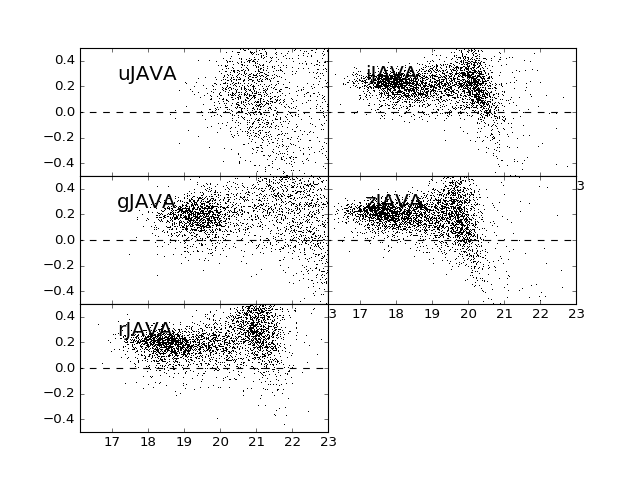

j-plus [INFO]: Fetching J-PLUS galaxies
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/jplus_allELGs_aperMags_upad_dual_magmax24.0.h5
j-plus [INFO]: Fetching SDSS galaxies
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/sdss_galaxies_aperMags_magmax24.0.h5


Replacing J-PUS BBs with SDSS BBs...
uJAVA uSDSS
Done replacing filters
gJAVA gSDSS
Done replacing filters
rJAVA rSDSS
Done replacing filters
iJAVA iSDSS
Done replacing filters
zJAVA zSDSS
Done replacing filters
Total number of tiles: 524
Total Number of candidates: 4281831 
J-PLUS ELG catalogue loaded


In [23]:
# Loading J-PLUS candidates


elgdir   = os.getcwd()
fout = '%s/out/elgs.dat' % elgdir
z_oii = [0.73, 0.79]
LoadJPLUSCat = False # if True loads a ELG catalogue of JPLUS already built
UseSDSSPhot = True # Use SDSS BB photometry instead of J-PLUS?
AddedPlots = True

if AddedPlots:
    plt.figure('PlotSDSSPhotometry')
    import matplotlib.gridspec as gsc
    gs = gsc.GridSpec(3,2)
    gs.update(wspace=0.0, hspace=0.0)

if LoadJPLUSCat:
    gal_elgs = pickle.load(open(fout))
else:
    mag_excess = "AND (m.MAG_APER_3_0[jplus::rSDSS]- m.MAG_APER_3_0[jplus::J0660]) > 0"
    gal_jplus = jplus.datasets.fetch_jplus_objects(mag_type="aperMags", overwrite=False, 
                                                 object_name="allELGs", nchunks=20, mag_limit=[16,24],
                                                extra_where_conds='',db='upad')
    ijlim = 0.0
    rjlim = 0.0
    
    if UseSDSSPhot:
        gal_sdss  = jplus.datasets.fetch_sdss_galaxies(mag_type="aperMags",overwrite=False,mag_limit=[16,24],nchunks=10)
        print 'Replacing J-PUS BBs with SDSS BBs...'
        d2,ind2 = jplus.tools.crossmatch_angular(gal_jplus['coords'],gal_sdss['coords'],max_distance=3e-4)
        m2 = ((d2 != np.inf))
        
        ix = 0
        iy = 0
        for f_jplus, f_sdss in zip(jplus.datasets.jplus_filter_names(only_bb = True), jplus.datasets.sdss_filter_names()):
            if AddedPlots:
                ax = plt.subplot(gs[ix,iy]) 
                print f_jplus, f_sdss
                ax.plot(gal_jplus[f_jplus][m2,0][0::25], 
                        gal_sdss[f_sdss][ind2[m2],0][0::25]-gal_jplus[f_jplus][m2,0][0::25],',',
                        color='black')
                ax.text(0.15,0.75,f_jplus,transform=ax.transAxes,fontsize=18)
                ax.set_xlim([16.1,23])
                ax.set_ylim([-.5,.5])
                ax.plot([16,23],[0,0],'--',color='black')
                if iy >0:
                    ax.set_yticklabels([])
                
                ix += 1                
                if ix == 3:
                    iy += 1
                    ix = 0
                    
                plt.draw()    
      
            gal_jplus[f_jplus][m2,:] = gal_sdss[f_sdss][ind2[m2],:]
            print 'Done replacing filters'

    gal_elgs = elg.make_selection(gal_jplus,ijlim = ijlim, rjlim = rjlim, makeplot= False)


    with open(fout,'wb') as outfile:
        pickle.dump(gal_elgs,outfile,protocol=pickle.HIGHEST_PROTOCOL)

    
elgtiles = np.unique(gal_elgs['tile_id'])




print 'J-PLUS ELG catalogue loaded'





In [22]:
print gal_sdss['SQL_query']

print gal_jplus['SQL_query']

SELECT  
   p.objid, p.ra, p.dec, 
   p.fiberMag_u as u, p.fiberMag_g as g, p.fiberMag_r as r, p.fiberMag_i as i, p.fiberMag_z as z,
   p.fiberMagErr_u as u_err, p.fiberMagErr_g as g_err, p.fiberMagErr_r as r_err, p.fiberMagErr_i as i_err, p.fiberMagErr_z as z_err
   , extinction_u, extinction_g, extinction_r, extinction_i, extinction_z
   , s.class, s.z as zspec, s.zerr as zspec_err, s.mjd, s.plate, s.fiberID, s.primtarget 
INTO mydb.MyTable 
FROM 
   dr14.photoobj AS p 
JOIN 
   dr14.SpecObj AS s 
ON 
   s.bestobjid = p.objid 
WHERE 
   p.r BETWEEN 16 AND 24
   AND s.class = 'GALAXY' AND (ABS(p.ra) - FLOOR(ABS(p.ra))) >= 0.0 AND (ABS(p.ra) - FLOOR(ABS(p.ra))) < 0.1
SELECT m.alpha_j2000 as ra, m.delta_j2000 as dec, 
   m.FWHM_WORLD*3600 as fwhm, m.CLASS_STAR as cstar, m.tile_id as tile_id, m.number as object_id, 
   m.KRON_RADIUS as kron_rad, m.PETRO_RADIUS as petro_rad, m.MU_MAX[jplus::rSDSS] as mu_max_r, 
   m.MAG_APER_3_0[jplus::uJAVA] as uJAVA, m.MAG_ERR_APER_3_0[jplus::uJAVA] as 

In [16]:
# Further selection cuts of ELGs:

fnames = jplus.datasets.jplus_filter_names()

mc = ((gal_elgs['mask_flags_rJAVA'] == 0) &
     (gal_elgs['mask_flags_iJAVA'] == 0) &
     (gal_elgs['mask_flags_J0660'] == 0) &
     (gal_elgs['single_detect_J0660'] != 0) &
     (gal_elgs['single_detect_iJAVA'] != 0) & 
     (gal_elgs['cstar'] < 0.25))

jplus_clean = jplus.tools.select_object(gal_elgs, mc)
    
        
print 'Original ELG selection contains %ld candidates' % len(gal_elgs['tile_id'])
print 'After removing non-single detections and masked objects, %ld' % len(jplus_clean['tile_id'])
frac = (len(jplus_clean['tile_id']) + 0.0)/(len(gal_elgs['tile_id'])+0.0)
print 'that is a fraction %f ' % frac


          

Original ELG selection contains 4281831 candidates
After removing non-single detections and masked objects, 1211392
that is a fraction 0.282914 


In [27]:


print dcone.dtype

f_j0660 = jplus.datasets.fetch_jplus_filter('J0660') # Filter transmission curve

w_oii = 3727.0 # OII rest-frame
z_oii = elg.zline(w_oii, f_j0660.wave, f_j0660.throughput)

w_ha = 6563.0
z_ha = elg.zline(w_ha, f_j0660.wave, f_j0660.throughput)

w_hb = 4861.0
z_hb = elg.zline(w_hb, f_j0660.wave, f_j0660.throughput)

w_oiii = 5007.0
z_oiii = elg.zline(w_oiii, f_j0660.wave, f_j0660.throughput)


print z_oii



j-plus [INFO]: Fetching  J-PLUS filters


[('Type', '<i4'), ('Mvir', '<f4'), ('pos', '<f4', (3,)), ('vel', '<f4', (3,)), ('sfr', '<f4'), ('sfr_inst', '<f4'), ('BulgeMass', '<f4'), ('DiskMass', '<f4'), ('Time', '<f4'), ('redshift', '<f4'), ('BlackholeMass', '<f4'), ('MetalColdGas', '<f4'), ('ColdGas', '<f4'), ('MassWeightAge', '<f4'), ('ObsMagDust', '<f4', (12,))]
[0.7482142815072982, 0.7964311035074512]


In [6]:
# Loading Convolved spectra

import learn_elgs as learn
tfout = '/home/CEFCA/aaorsi/work/elg_jplus/trainspec.dat'
allspec, photo_spec = learn.LoadSample(tfout,overwrite=False, sdssxjplus=False)



j-plus [INFO]: Fetching  J-PLUS filters


[-0.0072231255252628059, 0.020158269506669296]
[0.30129710948226485, 0.33718768179993419]
[0.34038153202585891, 0.37735007668633419]
[0.74821428150729818, 0.79643110350745117]


In [28]:

# Shortcuts for magnitudes

r_mock     = mtools.app_mag(dcone, 'rSDSS')
g_mock     = mtools.app_mag(dcone, 'gSDSS')
i_mock     = mtools.app_mag(dcone, 'iSDSS')
z_mock     = mtools.app_mag(dcone, 'zSDSS')
j0660_mock     = mtools.app_mag(dcone, 'J0660')
j0861_mock     = mtools.app_mag(dcone, 'J0861')

g_jplus = jplus_clean['gJAVA'][:,0]
r_jplus = jplus_clean['rJAVA'][:,0]
z_jplus = jplus_clean['zJAVA'][:,0]
i_jplus = jplus_clean['iJAVA'][:,0]
j0660_jplus = jplus_clean['J0660'][:,0]
j0861_jplus = jplus_clean['J0861'][:,0]


j0660_spec = photo_spec['J0660'][:,0]
j0861_spec = photo_spec['J0861'][:,0]
r_spec = photo_spec['rJAVA'][:,0]
i_spec = photo_spec['iJAVA'][:,0]
g_spec = photo_spec['gJAVA'][:,0]  # gJAVA, zJAVA are not fully sampled by VIMOS spectra (VVDS, VIPERS)
z_spec = photo_spec['zJAVA'][:,0]  # gJAVA, zJAVA are not fully sampled by VIMOS spectra (VVDS, VIPERS)




# Computing 3FM on each dataset
print 'Computing 3FM on mocks and J-PLUS ...'

dm_mocks = mtools.tfm(dcone,broad_noline='iSDSS')
dm_jplus = mtools.gen_3fm(jplus_clean['J0660'][:,0], jplus_clean['rJAVA'][:,0], 
                          jplus_clean['iJAVA'][:,0],Broad_NoLineName='iSDSS')

dm_spec = mtools.gen_3fm(photo_spec['J0660'][:,0], photo_spec['rJAVA'][:,0], 
                          photo_spec['iJAVA'][:,0],Broad_NoLineName='iSDSS')


print 'done'

mock_rlim = 21.3


cond_mocks = (dm_mocks > 0.4) & (r_mock > 20)
cond_jplus = (dm_jplus > 0.4) & (jplus_clean['rJAVA'][:,0] > 20) & (~np.isnan(dm_jplus)) & (jplus_clean['rJAVA'][:,0] < mock_rlim)
cond_spec  = (dm_spec > 0.4) & (r_spec > 20)


m_ha = cond_mocks & (dcone['redshift'] > z_ha[0]) & (dcone['redshift'] < z_ha[1])
m_hb = cond_mocks & (dcone['redshift'] > z_hb[0]) & (dcone['redshift'] < z_hb[1])
m_oii = cond_mocks & (dcone['redshift'] > z_oii[0]) & (dcone['redshift'] < z_oii[1])
m_oiii = cond_mocks & (dcone['redshift'] > z_oiii[0]) & (dcone['redshift'] < z_oiii[1])






Computing 3FM on mocks and J-PLUS ...
done


In [8]:
# Find Outliers with huge flux excess in J0660

bright = np.where(dm_jplus[cond_jplus] > 3.0)[0]
print bright

for b in bright:
    print b
    gal = gal_elgs
    print "http://upad.cefca.es/catalogues/jplus-v02/object_query.html?image=%s&number=%s"%(str(np.int(gal['tile_id'][b])),str(np.int(gal['object_id'][b])))
    ##jplus.tools.inspect_object(jplus.tools.select_object(gal_elgs,b))



[16343 24590]
16343
http://upad.cefca.es/catalogues/jplus-v02/object_query.html?image=26010&number=12342
24590
http://upad.cefca.es/catalogues/jplus-v02/object_query.html?image=26010&number=34658


['uJAVA', 'gJAVA', 'iJAVA', 'J0395', 'J0378', 'J0430', 'J0660', 'J0410', 'zJAVA', 'J0515', 'J0861', 'rJAVA']


<IPython.core.display.Javascript object>


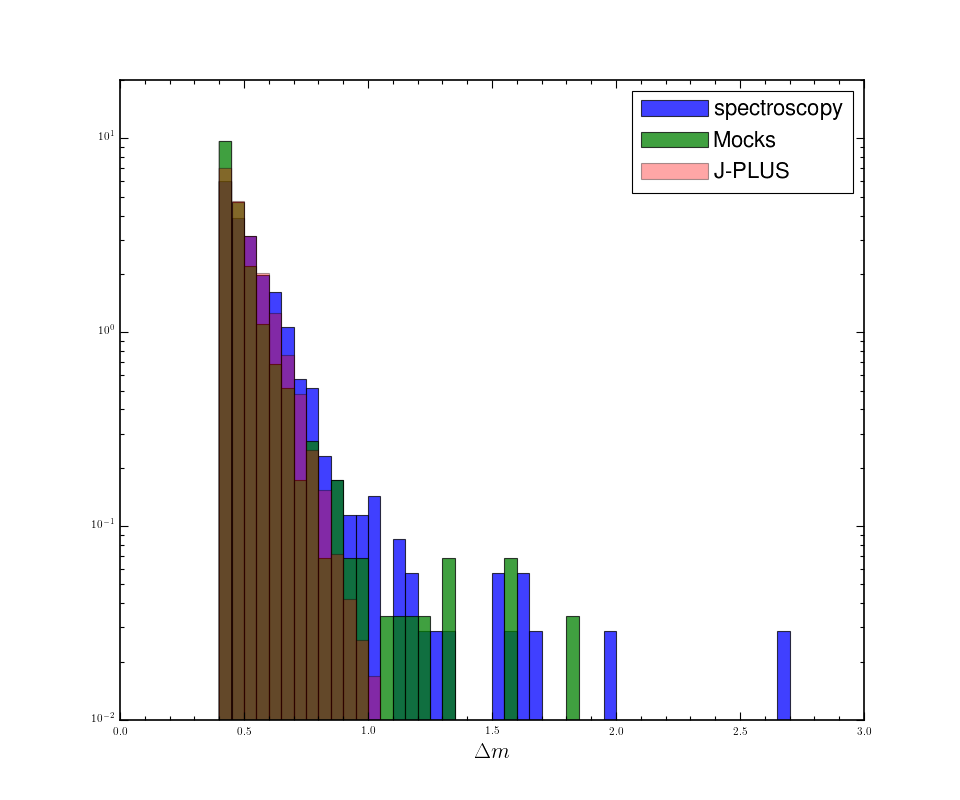

<IPython.core.display.Javascript object>


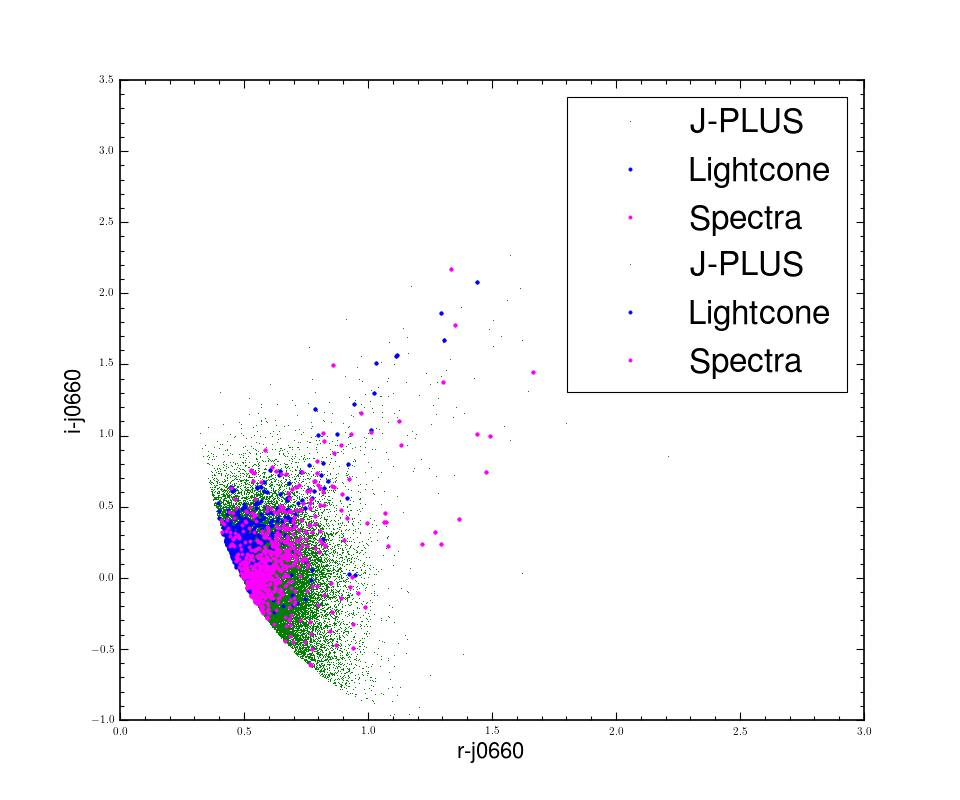

<IPython.core.display.Javascript object>


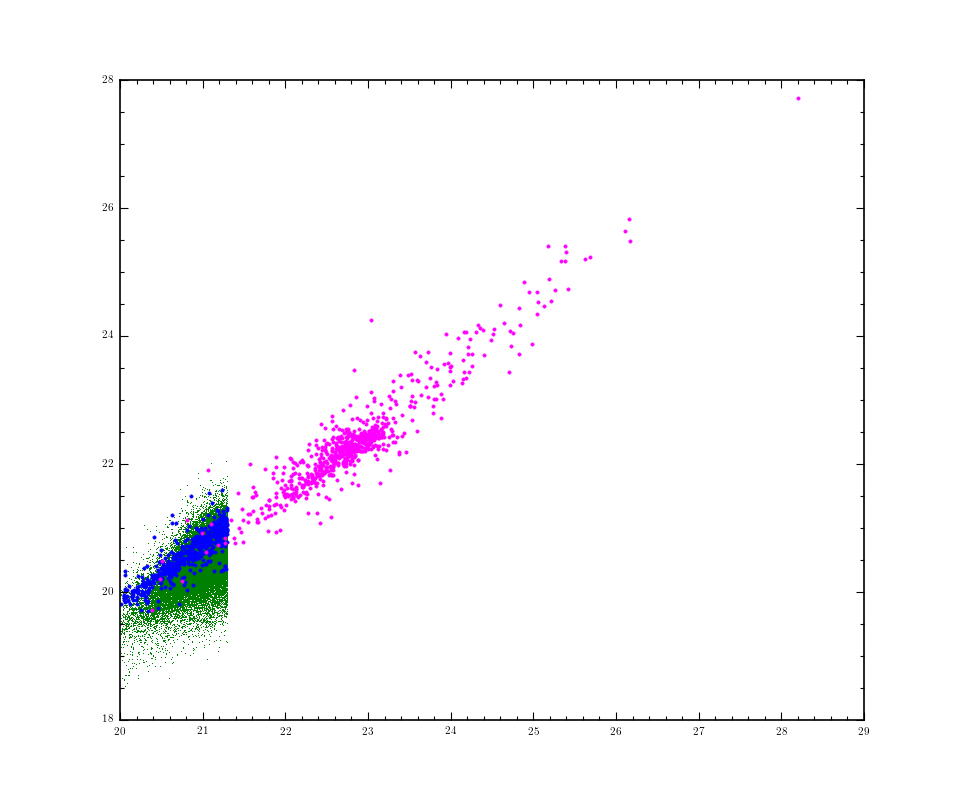

<IPython.core.display.Javascript object>


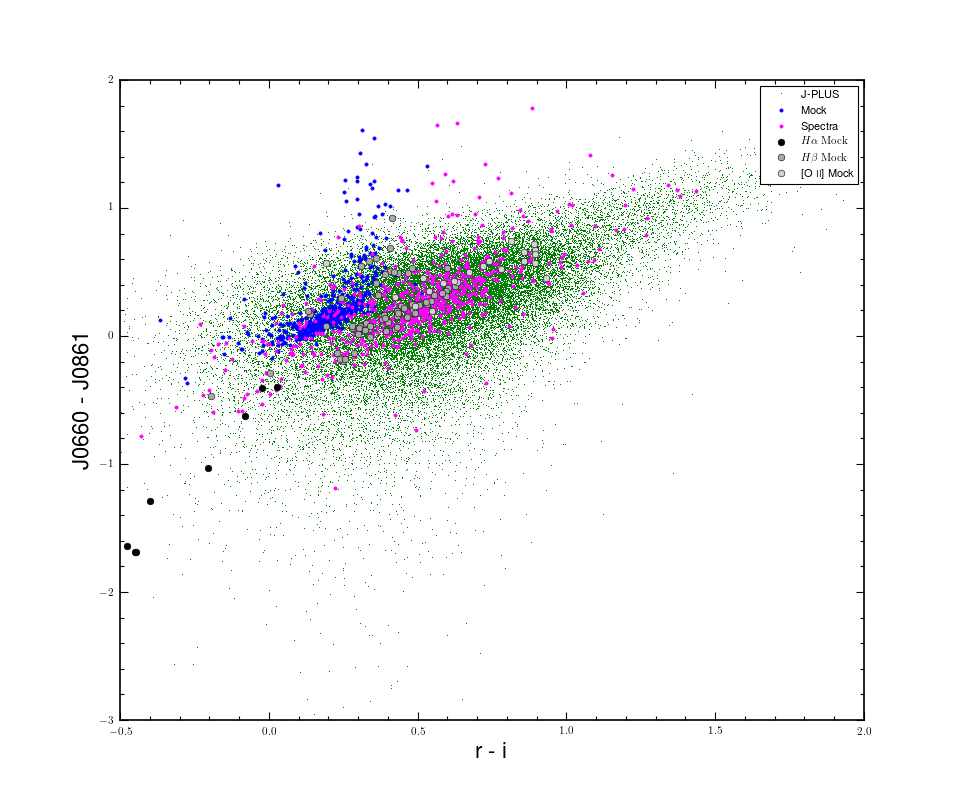

<IPython.core.display.Javascript object>


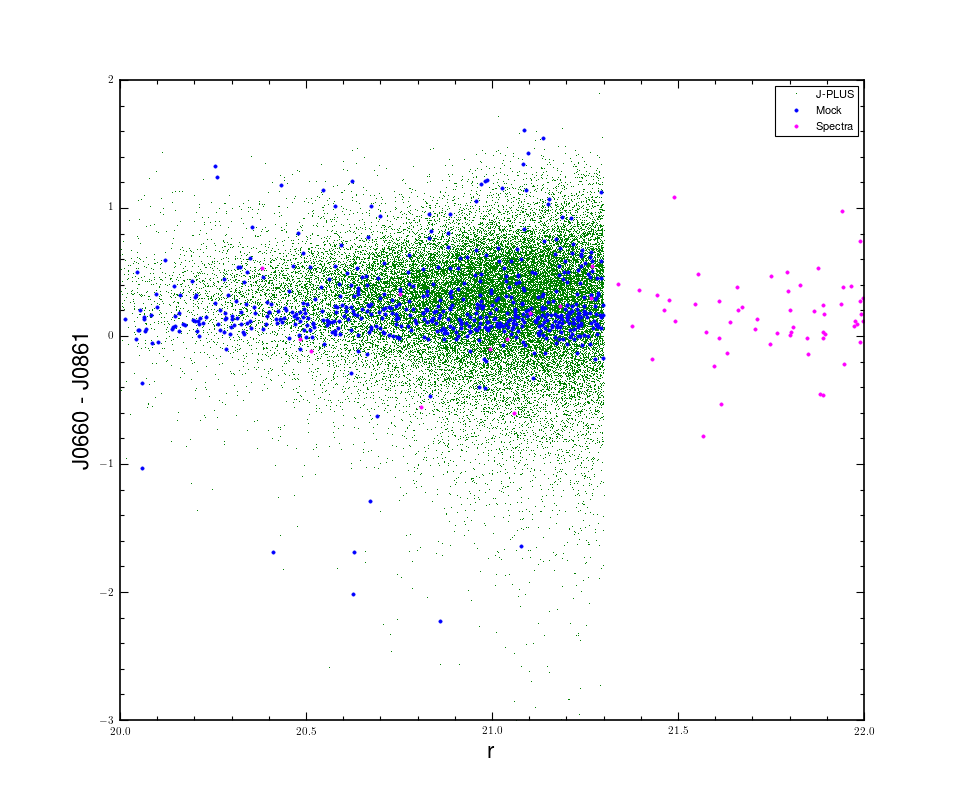

In [39]:
print photo_spec.keys()

plt.figure(4)

dm_bins = np.arange(0.4, 3., 0.05)

plt.hist(dm_spec[cond_spec],bins=dm_bins, label='spectroscopy', normed=True, alpha=0.75)
plt.hist(dm_mocks[cond_mocks],dm_bins,normed=True,facecolor='green',label='Mocks', alpha=0.75)
plt.hist(dm_jplus[cond_jplus],dm_bins,normed=True,facecolor='red',alpha=0.35,label='J-PLUS', log=True)
plt.xlim([0,3])
plt.ylim([1e-2, 2e1])
plt.xlabel(r'$\Delta m$', fontsize=20)
plt.legend(loc='upper right', fontsize=20)


plt.figure(5)
plt.plot(r_jplus[cond_jplus]-j0660_jplus[cond_jplus],i_jplus[cond_jplus]-j0660_jplus[cond_jplus],',',color='green', label='J-PLUS')
plt.plot(r_mock[cond_mocks]-j0660_mock[cond_mocks],i_mock[cond_mocks]-j0660_mock[cond_mocks],'.',color='blue', label='Lightcone')
plt.plot(r_spec[cond_spec]-j0660_spec[cond_spec],i_spec[cond_spec]-j0660_spec[cond_spec],'.',color='magenta',label='Spectra')

plt.xlabel('r-j0660',fontsize=20)
plt.ylabel('i-j0660',fontsize=20)
plt.legend(fontsize=30)


plt.figure(6)

plt.plot(r_jplus[cond_jplus],i_jplus[cond_jplus],',',color='green')
plt.plot(r_mock[cond_mocks],i_mock[cond_mocks],'.',color='blue')
plt.plot(r_spec[cond_spec],i_spec[cond_spec],'.',color='magenta')


plt.figure(5)
plt.plot(r_jplus[cond_jplus]-j0660_jplus[cond_jplus],i_jplus[cond_jplus]-j0660_jplus[cond_jplus],',',color='green', label='J-PLUS')
plt.plot(r_mock[cond_mocks]-j0660_mock[cond_mocks],i_mock[cond_mocks]-j0660_mock[cond_mocks],'.',color='blue', label='Lightcone')
plt.plot(r_spec[cond_spec]-j0660_spec[cond_spec],i_spec[cond_spec]-j0660_spec[cond_spec],'.',color='magenta',label='Spectra')

plt.xlabel('r-j0660',fontsize=20)
plt.ylabel('i-j0660',fontsize=20)
plt.legend(fontsize=30)

plt.figure(8)

plt.plot(r_jplus[cond_jplus]-i_jplus[cond_jplus],j0660_jplus[cond_jplus]-j0861_jplus[cond_jplus],',',color='green', label='J-PLUS')
plt.plot(r_mock[cond_mocks]-i_mock[cond_mocks],j0660_mock[cond_mocks]-j0861_mock[cond_mocks],'.',color='blue', label='Mock')
plt.plot(r_spec[cond_spec]-i_spec[cond_spec],j0660_spec[cond_spec]-j0861_spec[cond_spec],'.',color='magenta',label='Spectra')

plt.plot(r_mock[m_ha]-i_mock[m_ha],j0660_mock[m_ha]-j0861_mock[m_ha],'o',color='black', label=r'$H\alpha~{\rm Mock}$')
plt.plot(r_mock[m_hb]-i_mock[m_hb],j0660_mock[m_hb]-j0861_mock[m_hb],'o',color='darkgray', label=r'$H\beta~{\rm Mock}$')
plt.plot(r_mock[m_oii]-i_mock[m_oii],j0660_mock[m_oii]-j0861_mock[m_oii],'o',color='lightgray', label=r'[O \textsc{ii}] Mock')
plt.xlabel('r - i',fontsize=20)
plt.ylabel('J0660 - J0861',fontsize=20)
plt.xlim([-0.5,2])
plt.ylim([-3,2])
plt.legend()

plt.figure(9)

plt.plot(r_jplus[cond_jplus],j0660_jplus[cond_jplus]-j0861_jplus[cond_jplus],',',color='green', label='J-PLUS')
plt.plot(r_mock[cond_mocks],j0660_mock[cond_mocks]-j0861_mock[cond_mocks],'.',color='blue', label='Mock')
plt.plot(r_spec[cond_spec],j0660_spec[cond_spec]-j0861_spec[cond_spec],'.',color='magenta',label='Spectra')
plt.xlabel('r ',fontsize=20)
plt.ylabel('J0660 - J0861',fontsize=20)
plt.xlim([20,22])
plt.ylim([-3,2])
plt.legend()



In [10]:
len(allspec)

15314

<IPython.core.display.Javascript object>


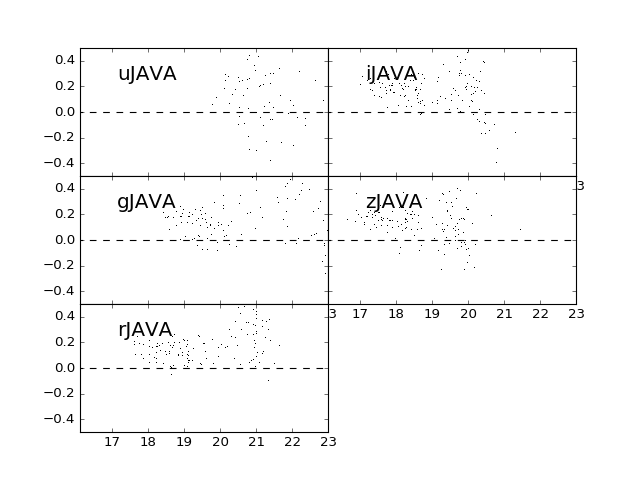

j-plus [INFO]: Fetching J-PLUS galaxies
j-plus [INFO]:    Connecting to the edr database
j-plus [INFO]: SELECT m.alpha_j2000 as ra, m.delta_j2000 as dec, 
   m.FWHM_WORLD*3600 as fwhm, m.CLASS_STAR as cstar, m.tile_id as tile_id, m.number as object_id, 
   m.KRON_RADIUS as kron_rad, m.PETRO_RADIUS as petro_rad, m.MU_MAX[jplus::rSDSS] as mu_max_r, 
   m.MAG_APER_3_0[jplus::uJAVA] as uJAVA, m.MAG_ERR_APER_3_0[jplus::uJAVA] as uJAVA_err, 
   m.MAG_APER_3_0[jplus::gSDSS] as gJAVA, m.MAG_ERR_APER_3_0[jplus::gSDSS] as gJAVA_err, 
   m.MAG_APER_3_0[jplus::rSDSS] as rJAVA, m.MAG_ERR_APER_3_0[jplus::rSDSS] as rJAVA_err, 
   m.MAG_APER_3_0[jplus::iSDSS] as iJAVA, m.MAG_ERR_APER_3_0[jplus::iSDSS] as iJAVA_err, 
   m.MAG_APER_3_0[jplus::zSDSS] as zJAVA, m.MAG_ERR_APER_3_0[jplus::zSDSS] as zJAVA_err, 
   m.MAG_APER_3_0[jplus::J0378] as J0378, m.MAG_ERR_APER_3_0[jplus::J0378] as J0378_err, 
   m.MAG_APER_3_0[jplus::J0395] as J0395, m.MAG_ERR_APER_3_0[jplus::J0395] as J0395_err, 
   m.MAG_APER_3_0[jp

Replacing J-PUS BBs with SDSS BBs...
uJAVA uSDSS
Done replacing filters
gJAVA gSDSS
Done replacing filters
rJAVA rSDSS
Done replacing filters
iJAVA iSDSS
Done replacing filters
zJAVA zSDSS
Done replacing filters


In [2]:
# Test on EDR



UseSDSSPhot = True # Use SDSS BB photometry instead of J-PLUS?
AddedPlots = True


plt.figure('PlotSDSSPhotometry_EDAM')
import matplotlib.gridspec as gsc
gs = gsc.GridSpec(3,2)
gs.update(wspace=0.0, hspace=0.0)

mag_excess = "AND (m.MAG_APER_3_0[jplus::rSDSS]- m.MAG_APER_3_0[jplus::J0660]) > 0"
gal_jplus = jplus.datasets.fetch_jplus_galaxies(mag_type="aperMags", overwrite=True, 
                                                 mag_limit=[16,24],
                                                db='edr')
    
if UseSDSSPhot:
    gal_sdss  = jplus.datasets.fetch_sdss_galaxies(mag_type="aperMags",overwrite=False,mag_limit=[16,24],nchunks=10)
    print 'Replacing J-PUS BBs with SDSS BBs...'
    d2,ind2 = jplus.tools.crossmatch_angular(gal_jplus['coords'],gal_sdss['coords'],max_distance=3e-4)
    m2 = ((d2 != np.inf))
        
    ix = 0
    iy = 0
    for f_jplus, f_sdss in zip(jplus.datasets.jplus_filter_names(only_bb = True), jplus.datasets.sdss_filter_names()):
        if AddedPlots:
            ax = plt.subplot(gs[ix,iy]) 
            print f_jplus, f_sdss
            ax.plot(gal_jplus[f_jplus][m2,0][0::25], 
                gal_sdss[f_sdss][ind2[m2],0][0::25]-gal_jplus[f_jplus][m2,0][0::25],',',
                color='black')
            ax.text(0.15,0.75,f_jplus,transform=ax.transAxes,fontsize=18)
            ax.set_xlim([16.1,23])
            ax.set_ylim([-.5,.5])
            ax.plot([16,23],[0,0],'--',color='black')
            if iy >0:
                ax.set_yticklabels([])
                
            ix += 1                
            if ix == 3:
                iy += 1
                ix = 0
                    
            plt.draw()    
      
        gal_jplus[f_jplus][m2,:] = gal_sdss[f_sdss][ind2[m2],:]
        print 'Done replacing filters'


